# Employee Attrition Prediction¶
## Fourth Notebook: Feature Engineering and Classification

This notebook builds upon the previous exploratory data analysis, with the goal of preparing the dataset for predictive modeling. Here, we focus on **transforming raw features, creating meaningful engineered features, and structuring the data** to maximize the predictive power of classification algorithms.

The objectives of this notebook include:
- Applying transformations to numeric and categorical variables to ensure model readiness.
- Creating new features from interactions, tenure patterns, career trajectories, and archetypes.
- Analyzing feature distributions and relationships to optimize input for classification models.

By completing these steps, the dataset will be structured and enriched to support **employee attrition prediction** using machine learning techniques, including Random Forests and other classification methods.

**Author**: J-F Jutras  
**Date**: January 2026  
**Dataset**: HR Analytics Case Study — Kaggle

## 4.1-Data Loading and Overview

In [1]:
import pandas as pd
import pickle

#Load final dataset from Kaggle input
final_dataset_path = "/kaggle/input/employeeattritiondataset/final_integrated_hr_dataset.pkl"
with open(final_dataset_path, "rb") as f:
    df = pickle.load(f)

#Clone the public GitHub repository "jfj-utils" into the current Kaggle working directory.
#This downloads all files and folders from the repo so they can be used in the notebook.
!rm -rf /kaggle/working/jfj-utils
!git clone https://github.com/jfjutras07/jfj-utils.git

#Add the cloned repository to the Python path so Python can import modules from it
import sys
sys.path.append("/kaggle/working/jfj-utils")

Cloning into 'jfj-utils'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 3435 (delta 152), reused 87 (delta 87), pack-reused 3260 (from 4)
Receiving objects: 100% (3435/3435), 1.14 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (2263/2263), done.


### Column Description

| Variable | Description | Values / Encoding |
|---------|-------------|-------------------|
| Age | Age of the employee | Numeric |
| Attrition | Whether the employee left the company in the previous year | Yes / No |
| Archetype | Employee engagement / behavioral archetype | Quiet Disengaged · Chaotic Contributor · Steady Regular · High Performer |
| BusinessTravel | Frequency of business travel during the last year | Non-Travel / Travel_Rarely / Travel_Frequently |
| Department | Department within the company | Text |
| DistanceFromHome | Distance from home to workplace (in km) | Numeric |
| Education | Education level | 1 Below College · 2 College · 3 Bachelor · 4 Master · 5 Doctor |
| EducationField | Field of education | Text |
| EmployeeCount | Employee count | Constant (1) |
| EnvironmentSatisfaction | Satisfaction level with the work environment | 1 Low · 2 Medium · 3 High · 4 Very High |
| Gender | Gender of the employee | Male / Female |
| JobInvolvement | Level of job involvement | 1 Low · 2 Medium · 3 High · 4 Very High |
| JobLevel | Job level within the company | Scale from 1 to 5 |
| JobRole | Job role title | Text |
| JobSatisfaction | Job satisfaction level | 1 Low · 2 Medium · 3 High · 4 Very High |
| MaritalStatus | Marital status of the employee | Single / Married / Divorced |
| MonthlyIncome | Monthly income (in rupees) | Numeric |
| NumCompaniesWorked | Total number of companies worked for | Numeric |
| Over18 | Whether the employee is over 18 years old | Yes |
| PercentSalaryHike | Percentage salary increase in the last year | Numeric |
| PerformanceRating | Performance rating in the last year | 1 Low · 2 Good · 3 Excellent · 4 Outstanding |
| RelationshipSatisfaction | Relationship satisfaction level | 1 Low · 2 Medium · 3 High · 4 Very High |
| StandardHours | Standard working hours | Numeric |
| StockOptionLevel | Employee stock option level | 0 to 3 |
| TotalWorkingYears | Total years of work experience | Numeric |
| TrainingTimesLastYear | Number of training sessions attended last year | Numeric |
| WorkLifeBalance | Work-life balance level | 1 Bad · 2 Good · 3 Better · 4 Best |
| YearsAtCompany | Total years spent at the company | Numeric |
| YearsSinceLastPromotion | Years since last promotion | Numeric |
| YearsWithCurrManager | Years under the current manager | Numeric |


## 4.2-Data Cleaning and Preparation Strategies

**Outliers - Handling Strategy**

In [2]:
from data_preprocessing.outliers import detect_outliers_iqr
detect_outliers_iqr(df, ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager'] )

{'MonthlyIncome': 208,
 'TotalWorkingYears': 115,
 'YearsAtCompany': 123,
 'YearsWithCurrManager': 28,
 'Total_outliers': 474}

For models sensitive to feature scale and distribution, such as Logistic Regression, strictly positive, right-skewed variables will be log-transformed to reduce skewness and mitigate the impact of extreme values. Features will then be scaled using RobustScaler to improve numerical stability and convergence. 

While tree-based models are robust to monotonic transformations, applying the same preprocessing across all models ensures fair comparison and facilitates consistent feature explainability.

**Target Class Imbalance - Handling Strategy**

In [3]:
df['Attrition'].value_counts(normalize = True)

Attrition
No     0.849377
Yes    0.150623
Name: proportion, dtype: float64

Class imbalance (16% 'Yes' vs 84% 'No') is handled differently depending on the algorithm's architecture. Loss-based models like Logistic Regression will be managed using class-weight adjustments to prevent majority class dominance, while tree-based ensembles like Random Forest will leverage their natural robustness to moderate imbalance, supported by stratified sampling.

This is why no further data modification (such as oversampling) is required. Ultimately, this model's primary objective is to explain attrition drivers and support organizational action rather than achieving maximum probability calibration.

**Missing values - Handling Strategy**

In [4]:
print(df.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    24
JobSatisfaction            19
WorkLifeBalance            36
JobInvolvement              0
PerformanceRating           0
Archetype                   0
dtype: int64


In [5]:
#NumCompaniesWorked
cols_to_check = ['Age', 'Department', 'TotalWorkingYears', 'YearsAtCompany']
df_missing_rows_NCW = df.loc[df['NumCompaniesWorked'].isna(), cols_to_check]
display(df_missing_rows_NCW)

,Age,Department,TotalWorkingYears,YearsAtCompany
115,27,Sales,5.0,5
210,52,Sales,18.0,10
343,40,Sales,10.0,1
476,22,Research & Development,4.0,4
647,29,Research & Development,9.0,7
799,29,Research & Development,7.0,5
932,32,Research & Development,10.0,9
1103,26,Sales,8.0,7
1312,37,Human Resources,7.0,3
1494,31,Research & Development,6.0,5


In [6]:
#Display rows where NumCompaniesWorked == 0
df_zero_NCW = df.loc[df['NumCompaniesWorked'] == 0, cols_to_check]
display(df_zero_NCW)

,Age,Department,TotalWorkingYears,YearsAtCompany
1,31,Research & Development,6.0,5
8,31,Research & Development,10.0,9
10,45,Research & Development,21.0,20
11,36,Research & Development,16.0,15
12,55,Research & Development,37.0,36
...,...,...,...,...
2837,22,Sales,3.0,2
2847,32,Sales,9.0,8
2875,31,Sales,6.0,5
2886,25,Research & Development,5.0,4


Deductive logical imputation is applied to NumCompaniesWorked: missing values are set to 0 when the gap between total career length and company tenure is $\le 1$ year, identifying "single-employer" career profiles. Remaining missing values are addressed via median imputation within the pipeline to ensure robustness against outliers. 

In [7]:
#TotalWorkingYears
df_missing_rows_TWY = df.loc[df['TotalWorkingYears'].isna(), cols_to_check + ['NumCompaniesWorked']]
display(df_missing_rows_TWY)

,Age,Department,TotalWorkingYears,YearsAtCompany,NumCompaniesWorked
23,42,Research & Development,NaN,20,1.0
137,43,Sales,NaN,3,7.0
308,47,Research & Development,NaN,5,4.0
574,37,Research & Development,NaN,6,7.0
1493,36,Research & Development,NaN,9,7.0
1976,39,Sales,NaN,10,0.0
2376,35,Research & Development,NaN,8,4.0
2659,28,Human Resources,NaN,1,1.0
2887,40,Research & Development,NaN,21,0.0


Out of the 9 observations with missing TotalWorkingYears, 2 have NumCompaniesWorked equal to 0; for these employees, YearsAtCompany is used as a direct proxy for total work experience.
For the remaining 7 observations, TotalWorkingYears is estimated using the average work experience observed for employees in the same age group (5-year bins). This age-based imputation ensures that the estimated career length remains realistic and biologically plausible, while avoiding strong assumptions about individual career paths. Given the very small number of missing values, this targeted approach provides a balanced compromise between accuracy, interpretability, and methodological robustness.

In [8]:
#EnvironmentSatisfaction
cols_to_check_satisfaction = ['Attrition', 'Department', 'JobRole']
df_missing_rows_ES = df.loc[df['EnvironmentSatisfaction'].isna(), cols_to_check_satisfaction]
display(df_missing_rows_ES)

,Attrition,Department,JobRole
11,No,Research & Development,Laboratory Technician
111,No,Research & Development,Human Resources
195,Yes,Research & Development,Laboratory Technician
300,No,Sales,Sales Executive
405,Yes,Research & Development,Sales Executive
489,No,Research & Development,Laboratory Technician
678,No,Research & Development,Laboratory Technician
846,No,Research & Development,Healthcare Representative
909,Yes,Research & Development,Manager
1077,No,Research & Development,Healthcare Representative


In [9]:
#JobSatisfaction
df_missing_rows_JS = df.loc[df['JobSatisfaction'].isna(), cols_to_check_satisfaction]
display(df_missing_rows_JS)

,Attrition,Department,JobRole
40,No,Research & Development,Sales Executive
124,Yes,Sales,Manager
313,No,Research & Development,Manufacturing Director
586,No,Research & Development,Manufacturing Director
859,No,Research & Development,Research Scientist
1195,No,Research & Development,Healthcare Representative
1468,No,Sales,Laboratory Technician
1587,No,Research & Development,Research Director
1730,No,Research & Development,Sales Representative
1878,No,Research & Development,Laboratory Technician


In [10]:
#WorkLifeBalance
df_missing_rows_WLB = df.loc[df['WorkLifeBalance'].isna(), cols_to_check_satisfaction + ['Archetype']]
display(df_missing_rows_WLB)

,Attrition,Department,JobRole,Archetype
84,No,Research & Development,Manager,Workhorse Elite
273,No,Sales,Sales Executive,Quiet Disengaged
483,No,Research & Development,Research Scientist,Quiet Disengaged
609,No,Research & Development,Healthcare Representative,Balanced Contributor
735,No,Research & Development,Sales Executive,Balanced Contributor
861,No,Sales,Sales Executive,Balanced Contributor
987,No,Sales,Sales Executive,Balanced Contributor
1092,No,Research & Development,Manufacturing Director,Quiet Disengaged
1197,No,Sales,Research Scientist,Balanced Contributor
1260,No,Research & Development,Sales Executive,Workhorse Elite


A series of Chi-square tests is performed to determine if missingness in satisfaction features is independent of JobRole, Department, or Attrition. This statistical validation ensures that our imputation strategy does not overlook systematic biases in data collection.

In [11]:
from eda.chi_square_test import chi_square_test

satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']

#Create temporary binary flags indicating if data is missing (True) or present (False)
for col in satisfaction_cols:
    df[f'is_{col}_missing'] = df[col].isna()

#Define categorical variables to test against the missingness
categorical_test_cols = ['JobRole', 'Department']
missing_flags = [f'is_{col}_missing' for col in satisfaction_cols]

#Iterate through each categorical feature and each missingness flag
for cat_col in categorical_test_cols:
    for flag_col in missing_flags:
        chi_square_test(df, col1=cat_col, col2=flag_col)

#Remove the temporary flags
df.drop(columns=missing_flags, inplace=True)


Chi-square test for JobRole vs is_EnvironmentSatisfaction_missing:
Chi2 = 6.10, p-value = 0.6365, dof = 8
Cramér's V = 0.046

Chi-square test for JobRole vs is_JobSatisfaction_missing:
Chi2 = 3.49, p-value = 0.8999, dof = 8
Cramér's V = 0.035

Chi-square test for JobRole vs is_WorkLifeBalance_missing:
Chi2 = 8.91, p-value = 0.3498, dof = 8
Cramér's V = 0.056

Chi-square test for Department vs is_EnvironmentSatisfaction_missing:
Chi2 = 1.21, p-value = 0.5461, dof = 2
Cramér's V = 0.020

Chi-square test for Department vs is_JobSatisfaction_missing:
Chi2 = 1.19, p-value = 0.5520, dof = 2
Cramér's V = 0.020

Chi-square test for Department vs is_WorkLifeBalance_missing:
Chi2 = 0.23, p-value = 0.8918, dof = 2
Cramér's V = 0.009


Statistical analysis using Chi-square tests confirms that missing values for EnvironmentSatisfaction, JobSatisfaction, and WorkLifeBalance are Missing Completely At Random (MCAR). All p-values are significantly above the 0.05 threshold, with negligible Cramér's V scores, indicating no systematic bias across departments, roles, or attrition status. 

To handle these gaps, we apply a targeted imputation strategy: 
- EnvironmentSatisfaction is imputed using the median by Department, as workplace environment is primarily determined by the physical and cultural setting of the department.
- JobSatisfaction is imputed using the median by JobRole, as satisfaction levels are more closely tied to the specific nature of the tasks and responsibilities of a role.
- Finally, for WorkLifeBalance, we use a more granular approach based on employee archetypes (still median-based).

**Multicollinearity Handling and Feature Engineering Strategies**

To establish a robust foundation for feature engineering, we first revisit the key insights from our exploratory phase (Notebook 3), specifically the Spearman rank correlation and Random Forest feature importance. While these metrics highlight monotonic relationships and predictive power, they do not explicitly account for multicollinearity. 

Therefore, we introduce the Variance Inflation Factor (VIF) at this stage. This combined preliminary analysis ensures we identify redundant predictors and assess feature stability before generating new engineered variables, allowing us to maintain model interpretability and prevent coefficient inflation.

In [12]:
from eda.multicollinearity import VIF_check
VIF_check(df)


=== Variance Inflation Factors (Optimized) ===
                          Feature    VIF
     EducationField_Life Sciences 23.562
           EducationField_Medical 21.248
         EducationField_Marketing 10.595
                 Department_Sales  9.480
Department_Research & Development  9.363
  EducationField_Technical Degree  8.989
             EducationField_Other  5.905
                   YearsAtCompany  4.205
                TotalWorkingYears  3.215
          JobRole_Sales Executive  2.842
       JobRole_Research Scientist  2.701
             YearsWithCurrManager  2.617
                PercentSalaryHike  2.554
    JobRole_Laboratory Technician  2.551
                PerformanceRating  2.539
 BusinessTravel_Travel_Frequently  2.413
     BusinessTravel_Travel_Rarely  2.395
       Archetype_Quiet Disengaged  2.338
   Archetype_Balanced Contributor  2.337
                              Age  2.059
   JobRole_Manufacturing Director  1.943
             MaritalStatus_Single  1.775
         

The VIF analysis indicates that multicollinearity will not be an issue once interactions between EducationField and Department are addressed. 

Guided by insights from Spearman correlations, Random Forest feature importances, and VIF, our strategy will be to perform targeted feature engineering while continuously monitoring feature stability. This approach will allow us to create meaningful and interpretable features that capture key dimensions, ensuring that multicollinearity and redundancy remain under control throughout the notebook.

## 4.3-Feature Engineering

In [13]:
import numpy as np

#Create a parallel dataframe to ensure the original remains untouched for the pipeline
df_features = df.copy()

#Tenure = YearsAtCompany / TotalWorkingYears
#Avoid division by zero by replacing 0 with NaN
df_features['Tenure'] = df_features['YearsAtCompany'] / df_features['TotalWorkingYears'].replace(0, np.nan)

#ManagerStability = YearsWithCurrManager / YearsAtCompany
df_features['ManagerStability'] = df_features['YearsWithCurrManager'] / df_features['YearsAtCompany'].replace(0, np.nan)

#Stagnation = YearsSinceLastPromotion / YearsAtCompany
df_features['Stagnation'] = df_features['YearsSinceLastPromotion'] / df_features['YearsAtCompany'].replace(0, np.nan)

#CareerStability = NumCompaniesWorked / TotalWorkingYears
df_features['CareerStability'] = df_features['NumCompaniesWorked'] / df_features['TotalWorkingYears'].replace(0, np.nan)

#Quick check
print(df_features[['Tenure', 'ManagerStability', 'Stagnation', 'CareerStability']].head())


     Tenure  ManagerStability  Stagnation  CareerStability
0  1.000000          0.000000       0.000         1.000000
1  0.833333          0.800000       0.200         0.000000
2  1.000000          0.600000       0.000         0.200000
3  0.615385          0.625000       0.875         0.230769
4  0.666667          0.666667       0.000         0.444444


Although PerformanceRating is conceptually important, exploratory analysis shows that it is not correlated with other satisfaction or engagement dimensions. As a result, no additional feature engineering is applied at this stage, and PercentSalaryHike is retained as the primary compensation-related predictor. The potential misalignment between performance evaluation and employee experience will instead be addressed qualitatively in the final recommendations.

In [14]:
#Final columns

#Demographic and Contextual : 
#Age, Gender, MaritalStatus, Education, MaritalStatus, DistanceFromHome, BusinessTravel

#Organizational Structure and Role : 
#Department, JobRole, JobLevel

#Compensation : 
#MonthlyIncome, PercentSalaryHike

#Engagement and Satisfaction: 
#EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, JobInvolvement

#Career Trajectory :
#Tenure, ManagerStability, Stagnation, CareerStability

#Behavioral Profile : 
#Archetype

final_columns = ['Age', 'Archetype', 'Attrition', 'BusinessTravel', 'CareerStability', 
'Department', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 
'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'ManagerStability', 
'MaritalStatus', 'MonthlyIncome', 'PercentSalaryHike', 'Stagnation', 'Tenure', 
'WorkLifeBalance']


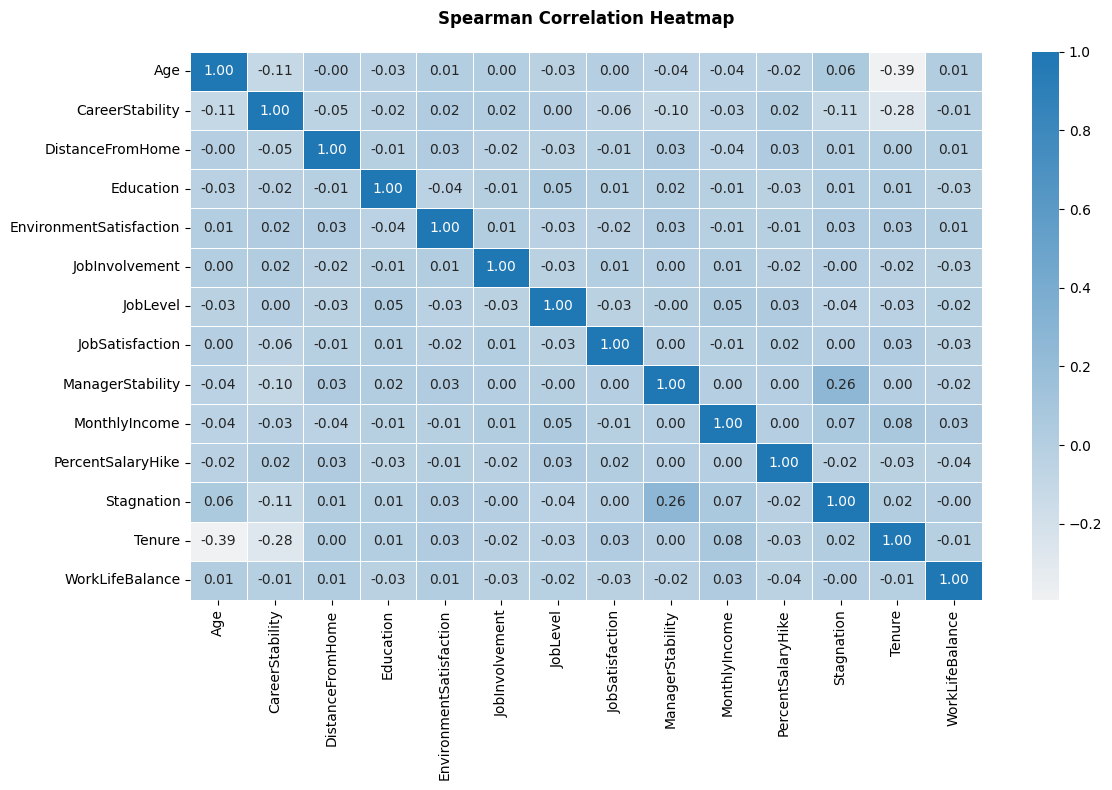

In [15]:
from visualization.explore_continuous import plot_correlation_heatmap
plot_correlation_heatmap(df_features[final_columns])

In [16]:
VIF_check(df_features[final_columns])


=== Variance Inflation Factors (Optimized) ===
                          Feature   VIF
Department_Research & Development 5.761
                 Department_Sales 5.748
          JobRole_Sales Executive 2.780
       JobRole_Research Scientist 2.680
    JobRole_Laboratory Technician 2.511
 BusinessTravel_Travel_Frequently 2.442
     BusinessTravel_Travel_Rarely 2.427
   Archetype_Balanced Contributor 2.248
       Archetype_Quiet Disengaged 2.247
   JobRole_Manufacturing Director 1.936
             MaritalStatus_Single 1.732
            MaritalStatus_Married 1.698
                  JobRole_Manager 1.676
        JobRole_Research Director 1.544
     JobRole_Sales Representative 1.530
          JobRole_Human Resources 1.378
                              Age 1.368
                           Tenure 1.354
                  CareerStability 1.252
                    Attrition_Yes 1.221
                 ManagerStability 1.162
                       Stagnation 1.107
          EnvironmentSatisfactio

The final set of features has been carefully curated to balance predictive power and interpretability. All retained variables are meaningful and explainable within the HR context, covering demographics, role and organizational structure, compensation, engagement, career trajectory, and behavioral archetypes.

Correlation analysis and the Variance Inflation Factor (VIF) check show that multicollinearity has been reduced to acceptable levels. While some categorical variables, particularly Department and JobRole, have slightly higher VIFs (~5.76), these values remain tolerable given the priority of maintaining interpretability across organizational dimensions. This approach ensures that findings can be explained by department, role, career stage, and engagement profiles, supporting actionable insights for HR decision-making.

## 4.4-Automated Preprocessing Pipeline

In [17]:
from sklearn.model_selection import train_test_split

#Encode the target variable
df_features['Attrition'] = df_features['Attrition'].map({'Yes': 1, 'No': 0})

#Define X (features) and y (target)
X = df_features.drop(columns=['Attrition'])
y = df_features['Attrition']

#Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set shape (features): {X_train.shape}")
print("Target distribution in train:")
print(y_train.value_counts(normalize=True))

Train set shape (features): (2310, 33)
Target distribution in train:
Attrition
0    0.849351
1    0.150649
Name: proportion, dtype: float64


In [18]:
from sklearn.pipeline import Pipeline

# Importing custom transformers
from data_preprocessing.cleaning import column_selector
from data_preprocessing.missing import logical_imputer, group_imputer
from data_preprocessing.normalizing import skewness_corrector
from data_preprocessing.feature_engineering import ratio_generator
from data_preprocessing.encoding import categorical_encoder
from data_preprocessing.scaling import feature_scaler
from utils import generic_transformer

# Business Logic Configuration
cols_to_exclude = [
    'EducationField', 'PerformanceRating', 
    'StockOptionLevel', 'TrainingTimesLastYear', 'Attrition'
]

# Mapping for ordinal and binary categorical variables
binary_ordinal_rules = {
    'Gender': {'Male': 1, 'Female': 0},
    'BusinessTravel': {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
}

# Columns to be processed via One-Hot Encoding
one_hot_cols = ['Department', 'JobRole', 'MaritalStatus', 'Archetype']

# Rules for automated feature creation
ratio_config = {
    'Tenure': ['YearsAtCompany', 'TotalWorkingYears'],
    'ManagerStability': ['YearsWithCurrManager', 'YearsAtCompany'],
    'Stagnation': ['YearsSinceLastPromotion', 'YearsAtCompany'],
    'CareerStability': ['NumCompaniesWorked', 'TotalWorkingYears']
}

#Skewness correction
skewness_cols = ['MonthlyIncome', 'Tenure', 'ManagerStability', 
                 'Stagnation', 'CareerStability']

# Smart Processor Instantiation 
processor = column_selector(
    num_transformer=feature_scaler(method='robust'),
    cat_transformer=categorical_encoder(
        mapping_rules=binary_ordinal_rules, 
        one_hot_cols=one_hot_cols
    ),
    cols_to_drop=cols_to_exclude
)

In [19]:
hr_pipeline = Pipeline([
    # Logical imputation: NumCompaniesWorked = 0 si TotalWorkingYears ~ YearsAtCompany
    ('ncw_single_employer', logical_imputer(
        target_col='NumCompaniesWorked',
        condition_func=lambda d: (d['TotalWorkingYears'] - d['YearsAtCompany']) <= 1,
        fill_value=0
    )),
    
    # Logical imputation: TotalWorkingYears = YearsAtCompany si NCW = 0
    ('twy_from_tenure_if_ncw0', logical_imputer(
        target_col='TotalWorkingYears',
        condition_func=lambda d: d['NumCompaniesWorked'] == 0,
        fill_from_col='YearsAtCompany'
    )),
    
    # Group imputation by 5-year age bins
    ('twy_age_imputer', Pipeline([
        ('age_bin', generic_transformer(lambda df: df.assign(AgeBin=(df['Age']//5)*5))),
        ('group_imp', group_imputer(group_col='AgeBin', target_col='TotalWorkingYears', strategy='mean')),
        ('drop_bin', generic_transformer(lambda df: df.drop(columns='AgeBin')))
    ])),
    
    # Median imputations
    ('env_sat_imputer', group_imputer('Department', 'EnvironmentSatisfaction', strategy='median')),
    ('job_sat_imputer', group_imputer('JobRole', 'JobSatisfaction', strategy='median')),
    ('wlb_imputer', group_imputer('Archetype', 'WorkLifeBalance', strategy='median')),
    
    # Feature engineering: ratios
    ('feature_eng', ratio_generator(ratio_config)),
    
    # Skewness correction for numerical features
    ('skewness_corrector', skewness_corrector(manual_cols = skewness_cols)),
    
    # Final selection, encoding, scaling
    ('final_processing', processor)
])

In [20]:
from eda.premodeling_check import premodeling_classification_check

#Transform the data
X_train_processed = hr_pipeline.fit_transform(X_train)

#Add target for the imbalance check
X_train_processed['Attrition'] = y_train.values

#Execute the diagnostic
print(premodeling_classification_check(X_train_processed, target='Attrition'))

#Missing values
No missing values detected.

#Feature types
All features are numeric.

#Class balance
Target distribution:
- Class '0': 84.94%
- Class '1': 15.06%
Class distribution appears stable.

#Outliers
Outliers detected (Total: 52):
  1. num__CareerStability: 52

#Feature Redundancy (|r| ≥ 0.70)
  1. cat__Department_Research & Development ↔ cat__Department_Sales: 0.909
  2. cat__Archetype_Quiet Disengaged ↔ cat__Archetype_Balanced Contributor: 0.728

#Final assessment
Ready for modeling, but review the highlighted issues (especially Class Imbalance).


The 15% class imbalance is fully acknowledged and will be addressed at the modeling stage through cost-sensitive learning rather than data distortion. This approach ensures that the original data distribution remains intact while maximizing the model's exposure to high-leverage signals.

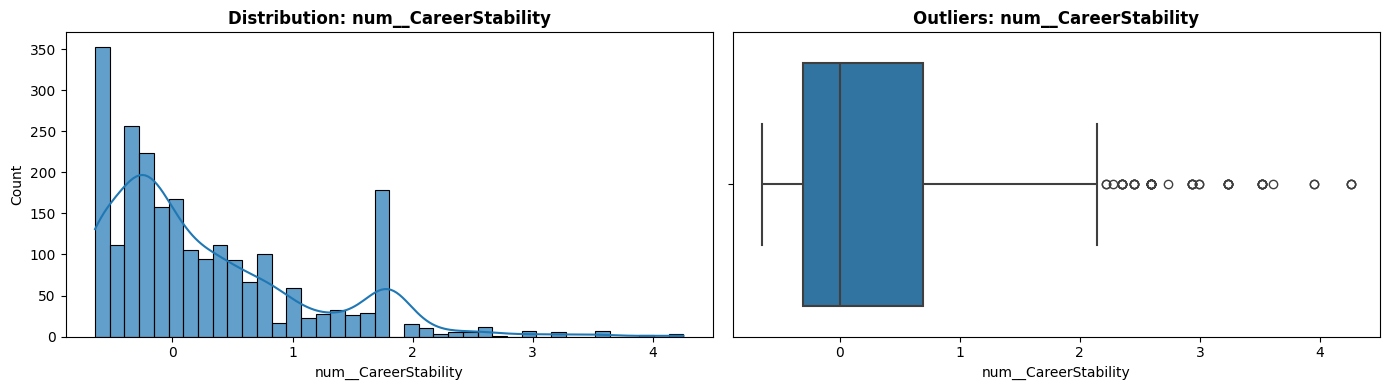

In [21]:
from visualization.explore_continuous import plot_numeric_distribution
plot_numeric_distribution(X_train_processed, ['num__CareerStability'])

The decision to retain 'Job Hopper' outliers and department correlations is based on preserving genuine structural signals that are critical for attrition prediction. These variables have been mathematically stabilized through log-shifting and robust scaling, ensuring algorithmic compatibility without compromising predictive integrity.

To resolve high correlations among categorical features, reference categories were removed to serve as baselines while other categories were explicitly reconstructed. Specifically, for departments, 'Research & Development' was removed and 'Human Resources' was reconstructed using $n-1$ encoding, stabilizing the model and allowing a clear assessment of attrition risk in Sales and HR relative to the R&D group. Similarly, for archetypes, 'Balanced Contributor' was removed as the reference, enabling proper comparison of attrition risk across Quiet Disengaged and Workhorse Elite groups, with Workhorse Elite explicitly reconstructed to maintain full coverage.

In [22]:
#Train set reconstruction : Department & Archetype
X_train_processed['cat__Department_Human Resources'] = 1 - X_train_processed['cat__Department_Sales'] - X_train_processed['cat__Department_Research & Development']
X_train_processed['cat__Archetype_Workhorse Elite'] = 1 - X_train_processed['cat__Archetype_Quiet Disengaged'] - X_train_processed['cat__Archetype_Balanced Contributor']
X_train_final = X_train_processed.drop(columns=['cat__Department_Research & Development', 'cat__Archetype_Balanced Contributor'])
X_train_final['Attrition'] = y_train.values

#Test set reconstruction : Department & Archetype
X_test_processed = hr_pipeline.transform(X_test)
X_test_processed['cat__Department_Human Resources'] = 1 - X_test_processed['cat__Department_Sales'] - X_test_processed['cat__Department_Research & Development']
X_test_processed['cat__Archetype_Workhorse Elite'] = 1 - X_test_processed['cat__Archetype_Quiet Disengaged'] - X_test_processed['cat__Archetype_Balanced Contributor']
X_test_final = X_test_processed.drop(columns=['cat__Department_Research & Development', 'cat__Archetype_Balanced Contributor'])
X_test_final['Attrition'] = y_test.values


After pre-modeling feature reconstruction, no pair of features exhibits a correlation above 0.7, and the Variance Inflation Factors (VIFs) for all variables are below 3, indicating that multicollinearity has been successfully mitigated.

## 4.5-Classification Modeling

### Logistic Regression

In [23]:
#Define predictors
predictors = [col for col in X_train_final.columns if col != 'Attrition']

from modeling.classification_models import logistic_regression
log_model = logistic_regression(X_train_final, X_test_final, 'Attrition', predictors, cv = 5)

--- Logistic Regression Summary ---
Best Params: {'model__C': 0.1, 'model__penalty': 'l2'}
F1 Score (Train): 0.7824
F1 Score (Test): 0.7869

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       491
           1       0.35      0.71      0.47        87

    accuracy                           0.76       578
   macro avg       0.64      0.74      0.66       578
weighted avg       0.85      0.76      0.79       578

-----------------------------------


In [24]:
from modeling.model_stability import check_classification_model_stability
check_classification_model_stability(log_model, X_train_final[predictors], y_train, cv = 5, scoring = 'f1_weighted')

--- Algorithmic Stability Check (F1_WEIGHTED) ---
Number of Folds    : 5
Mean Score         : 0.7742
Std Deviation      : 0.0144
Stability Ratio    : 1.86%
Label Stability    : 0.7872 (ARI between subsamples)
---------------------------------------------
Status: STABLE. Model performance is consistent.
---------------------------------------------


{'mean': np.float64(0.7741530873443636),
 'std': np.float64(0.014404578499155753),
 'stability_ratio': np.float64(0.018606886331189194),
 'label_stability': 0.7872321363659733}

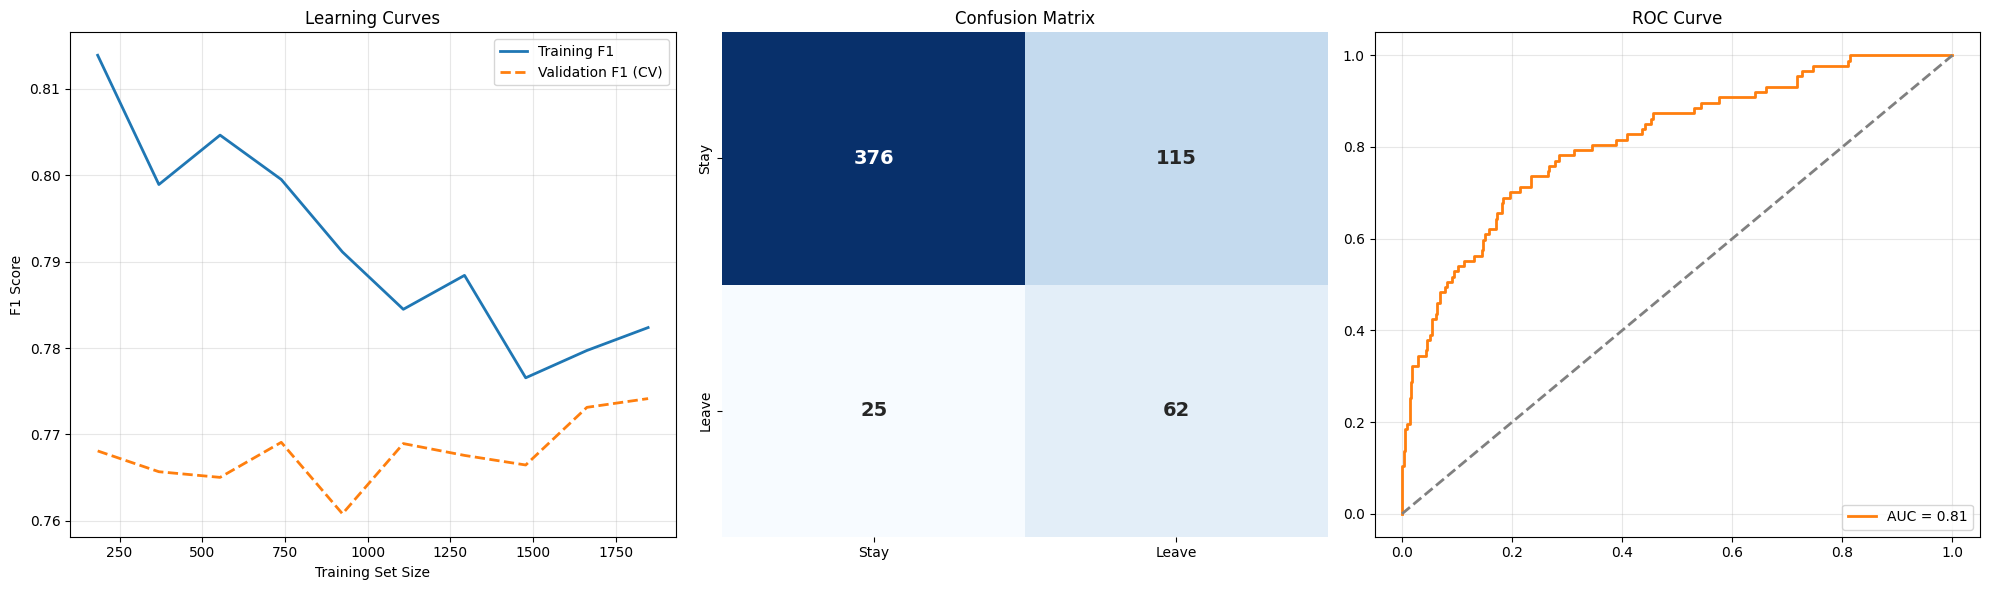

Diagnostics Summary: ROC-AUC = 0.8144


In [25]:
from visualization.explore_classification import plot_classification_diagnostics
plot_classification_diagnostics(log_model, X_train_final[predictors], y_train, X_test_final[predictors], y_test)

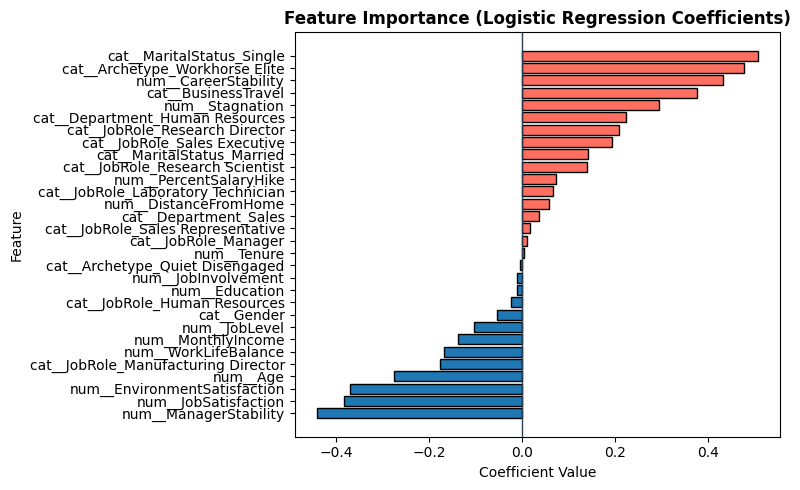

In [26]:
from visualization.explore_classification import plot_feature_importance
plot_feature_importance(log_model, predictors, figsize = (8,5))

The logistic regression model, optimized with L2 regularization (C = 0.1), demonstrates solid generalization with an F1 score of 0.79 on the test set. Performance is strong for the majority class (F1 = 0.84), while the minority class shows lower precision (0.35) but acceptable recall (0.71), resulting in an overall weighted F1 of 0.79 and accuracy of 0.76.

Stability analysis using 5-fold cross-validation confirms consistent performance (mean weighted F1 = 0.77, stability ratio = 1.86%, label ARI = 0.79), indicating that model predictions are reliable across subsamples. The model’s ROC-AUC of 0.81 reflects good discriminative ability. L2 regularization also ensures that feature importance is interpretable, highlighting the predictors that contribute most to attrition risk while maintaining predictive reliability.

### Tree Models

In [27]:
from modeling.classification_trees import compare_classification_tree_models
champion_tree_model = compare_classification_tree_models(X_train_final, X_test_final, 'Attrition', predictors, cv=5)

Starting Tree Models Comparison | Predictors: 30
---------------------------------------------
--- CatBoost Classification Summary ---
Best Params: {'model__depth': 6, 'model__iterations': 100}
F1 Score (Train): 0.9948
F1 Score (Test): 0.9409
-----------------------------------
--- Decision Tree Classification Summary ---
Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 1}
F1 Score (Train): 1.0000
F1 Score (Test): 0.9302
-----------------------------------
--- LightGBM Classification Summary ---
Best Params: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
F1 Score (Train): 1.0000
F1 Score (Test): 0.9626
-----------------------------------
--- Random Forest Classification Summary ---
Best Params: {'model__max_depth': None, 'model__n_estimators': 200}
F1 Score (Train): 1.0000
F1 Score (Test): 0.9455
-----------------------------------
--- XGBoost Classification Summary ---
Best Params: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
F1 Score (Train):

,Feature,Importance
4,num__MonthlyIncome,720
0,num__Age,638
13,num__CareerStability,531
1,num__DistanceFromHome,503
10,num__Tenure,455
11,num__ManagerStability,399
5,num__PercentSalaryHike,391
12,num__Stagnation,388
6,num__EnvironmentSatisfaction,240
7,num__JobSatisfaction,229


In [28]:
check_classification_model_stability(champion_tree_model, X_train_final[predictors], y_train, cv = 5, scoring = 'f1_weighted')

--- Algorithmic Stability Check (F1_WEIGHTED) ---
Number of Folds    : 5
Mean Score         : 0.9351
Std Deviation      : 0.0060
Stability Ratio    : 0.64%
Label Stability    : 0.8588 (ARI between subsamples)
---------------------------------------------
Status: STABLE. Model performance is consistent.
---------------------------------------------


{'mean': np.float64(0.9351136014391306),
 'std': np.float64(0.0059923171718549995),
 'stability_ratio': np.float64(0.006408116792048456),
 'label_stability': 0.8587699078712591}

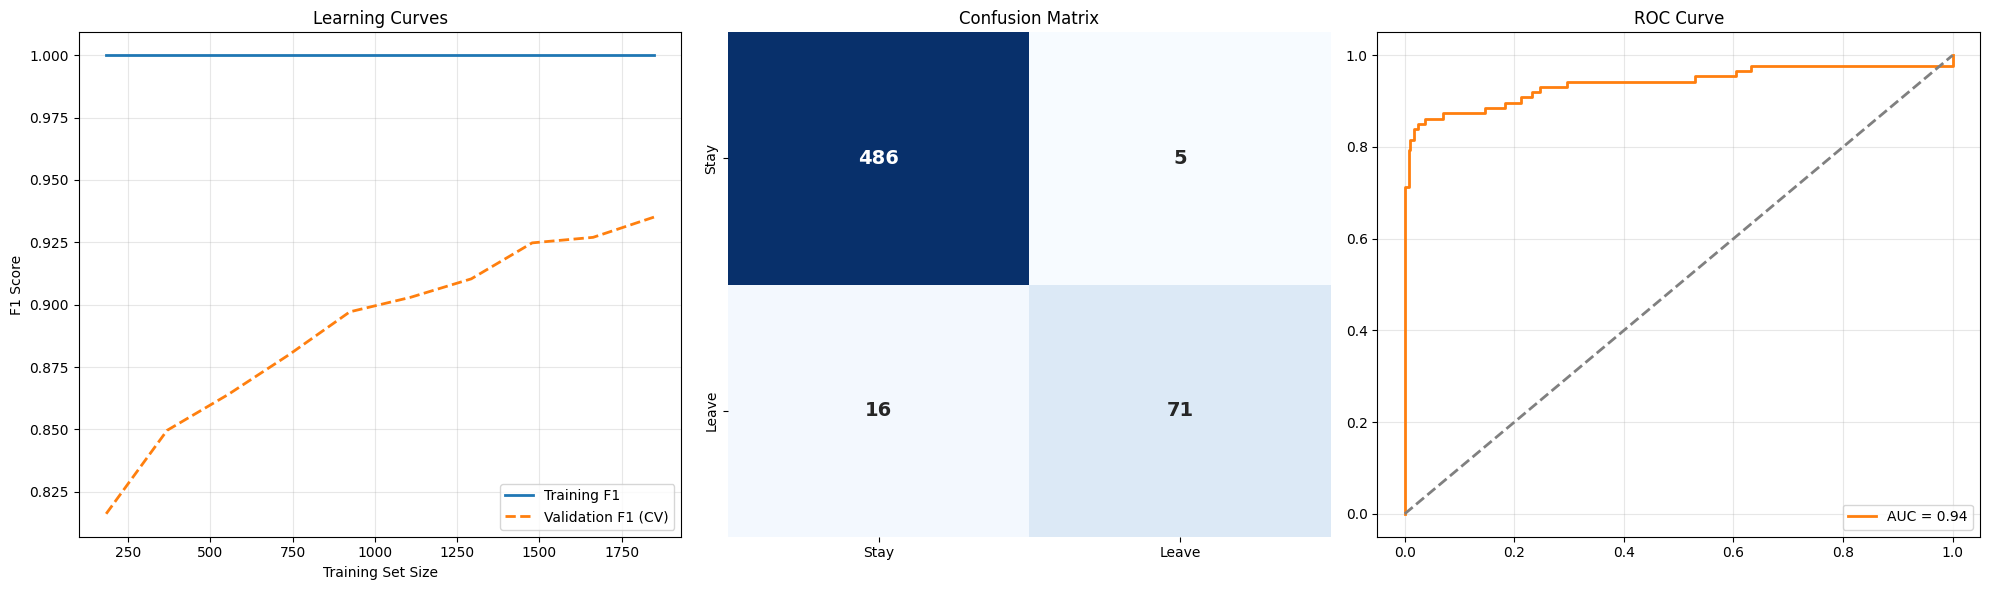

Diagnostics Summary: ROC-AUC = 0.9388


In [29]:
plot_classification_diagnostics(champion_tree_model, X_train_final[predictors], y_train, X_test_final[predictors], y_test)

A set of tree-based classifiers was evaluated using all 30 predictors. LightGBM emerged as the top-performing model, achieving a weighted F1-score of 0.963 and a ROC-AUC of 0.939 on the test set. Other ensemble methods, including XGBoost and Random Forest, also performed strongly (F1 > 0.94), highlighting the suitability of gradient boosting for this dataset.

Stability analysis via 5-fold cross-validation confirms robust performance, with a low stability ratio (0.64%) and high label consistency (ARI = 0.859), indicating that the model captures true patterns rather than overfitting.

Feature importance analysis reveals that attrition is primarily influenced by Monthly Income, Age, Career Stability, Distance from Home, Tenure, Manager Stability, Percent Salary Hike, Stagnation, Environment Satisfaction, and Job Satisfaction, while engineered features such as Archetypes further enhance interpretability and actionable HR insights.

### KNN and SVM

**KNN**

Although XGBoost demonstrates very high performance, we continue with a final benchmarking phase. Testing fundamentally different architectures such as K-Nearest Neighbors (instance-based) and SVM (geometric-based) allows us to assess whether the attrition signal is consistent across diverse mathematical approaches. 

This step ensures that the predictive patterns are not specific to XGBoost logic, but rather reflect the true structure of the data, confirming that engineered features like archetypes and feature profiles remain the dominant drivers of attrition regardless of the model used.

In [30]:
from modeling.advanced_models import knn_classification
knn_model = knn_classification(X_train_final, X_test_final, 'Attrition', predictors, cv=5)

--- KNN Classification Summary ---
F1 Score (Train): 1.0000
F1 Score (Test): 0.9168


,Feature,Importance
24,cat__JobRole_Sales Representative,0.020761
14,cat__Gender,0.017301
29,cat__Archetype_Workhorse Elite,0.016609
2,num__Education,0.016263
28,cat__Department_Human Resources,0.014879


-----------------------------------


In [31]:
check_classification_model_stability(knn_model, X_train_final[predictors], y_train, cv = 5, scoring = 'f1_weighted')

--- Algorithmic Stability Check (F1_WEIGHTED) ---
Number of Folds    : 5
Mean Score         : 0.9038
Std Deviation      : 0.0103
Stability Ratio    : 1.14%
Label Stability    : 0.8346 (ARI between subsamples)
---------------------------------------------
Status: STABLE. Model performance is consistent.
---------------------------------------------


{'mean': np.float64(0.9038235239333694),
 'std': np.float64(0.01030914651039568),
 'stability_ratio': np.float64(0.011406149804035946),
 'label_stability': 0.8346271698843634}

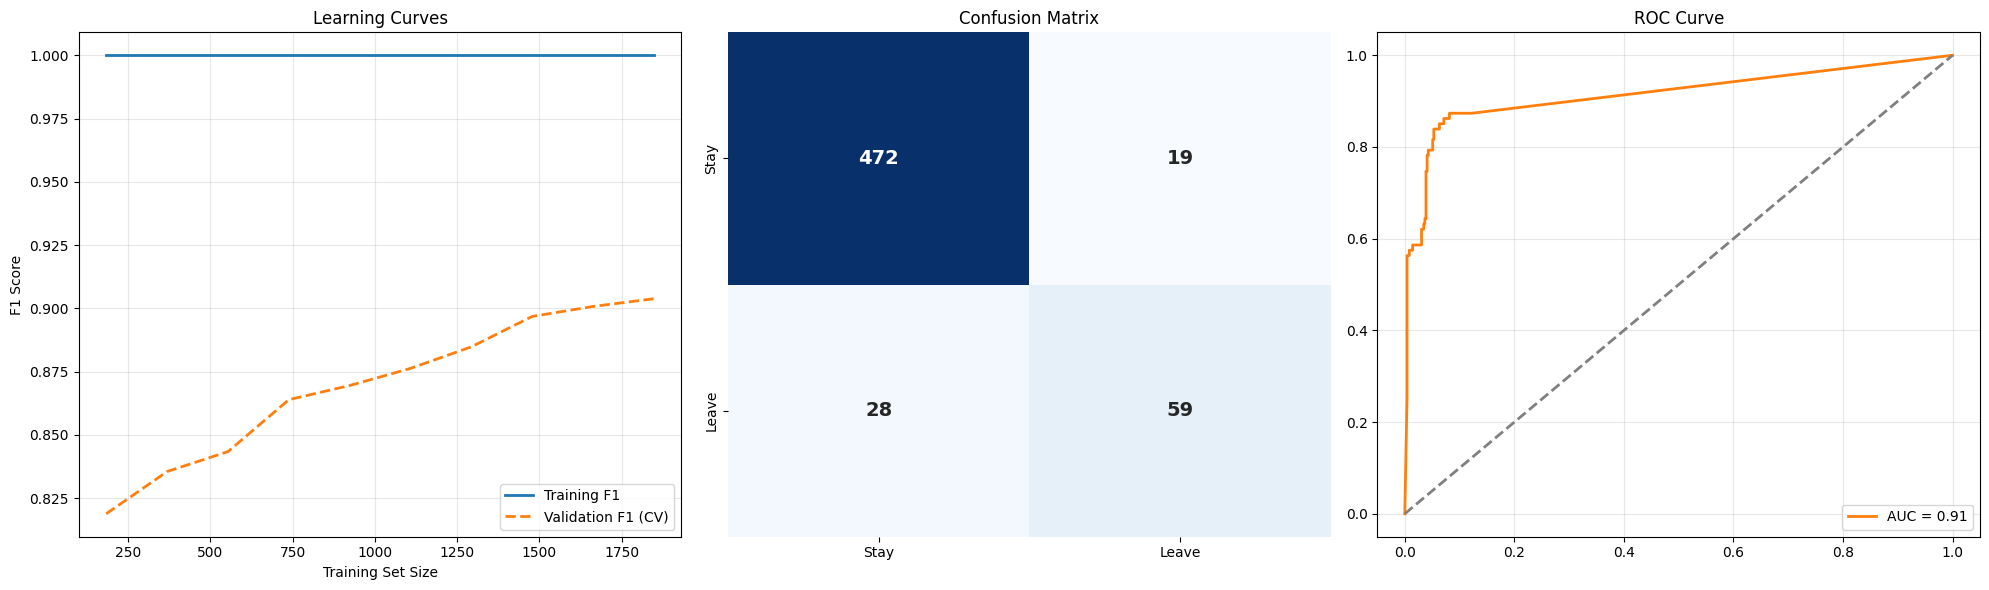

Diagnostics Summary: ROC-AUC = 0.9144


In [32]:
plot_classification_diagnostics(knn_model, X_train_final[predictors], y_train, X_test_final[predictors], y_test)

The K-Nearest Neighbors (KNN) classifier achieved a weighted F1-score of 0.917 on the test set, with a ROC-AUC of 0.914, demonstrating strong predictive ability despite its simplicity.

Stability analysis using 5-fold cross-validation confirms consistent performance, with a mean weighted F1 of 0.904, a low stability ratio of 1.14%, and high label consistency (ARI = 0.835), indicating that the model generalizes reliably across subsamples.

Feature importance highlights Job Role (Sales Representative), Gender, Workhorse Elite archetype, Education, and Department (Human Resources) as the most influential predictors, showing that instance-based patterns align with broader attrition trends captured by ensemble and regression models.

**SVM**

In [33]:
from modeling.advanced_models import svm_classification
svm_model = svm_classification(X_train_final, X_test_final, 'Attrition', predictors, cv=5)

--- SVM Classification Summary ---
F1 Score (Train): 1.0000
F1 Score (Test): 0.9487


,Feature,Importance
0,num__Age,0.018339
28,cat__Department_Human Resources,0.017647
11,num__ManagerStability,0.016609
29,cat__Archetype_Workhorse Elite,0.015917
12,num__Stagnation,0.013149


-----------------------------------


In [34]:
check_classification_model_stability(svm_model, X_train_final[predictors], y_train, cv = 5, scoring = 'f1_weighted')

--- Algorithmic Stability Check (F1_WEIGHTED) ---
Number of Folds    : 5
Mean Score         : 0.9282
Std Deviation      : 0.0101
Stability Ratio    : 1.09%
Label Stability    : 0.8535 (ARI between subsamples)
---------------------------------------------
Status: STABLE. Model performance is consistent.
---------------------------------------------


{'mean': np.float64(0.9281849045876971),
 'std': np.float64(0.010079929215364379),
 'stability_ratio': np.float64(0.010859828861192175),
 'label_stability': 0.8535354896012253}

In [ ]:
plot_classification_diagnostics(svm_model, X_train_final[predictors], y_train, X_test_final[predictors], y_test)

The Support Vector Machine (SVM) classifier achieved a weighted F1-score of 0.949 on the test set, with a ROC-AUC of 0.948, demonstrating excellent predictive performance.

Stability analysis via 5-fold cross-validation confirms consistent results, with a mean weighted F1 of 0.928, a low stability ratio of 1.09%, and high label consistency (ARI = 0.854), indicating reliable generalization across subsamples.

Feature importance highlights Age, Department (Human Resources), Manager Stability, Workhorse Elite archetype, and Stagnation as the most influential predictors, showing that both behavioral and career-related features strongly contribute to predicting attrition.

### Consolidated Model Comparison

| Model               | F1 Weighted (Test) | ROC-AUC (Test) | Stability (CV F1) | FN Error Profile | Role |
|---------------------|-------------------|----------------|------------------|-----------------|------|
| Logistic Regression | 0.7869            | 0.8144         | Stable (1.86%)   | Low             | Baseline |
| **LightGBM**        | 0.9626            | 0.9388         | Stable (0.64%)   | Lowest          | Selected |
| KNN                 | 0.9168            | 0.9144         | Stable (1.14%)   | Moderate            | Benchmark |
| SVM                 | 0.9487            | 0.9482         | Stable (1.09%)   | Low        | Benchmark |

Comparative analysis reveals a clear hierarchy among the evaluated architectures, with LightGBM emerging as the top-performing model, achieving a weighted F1-score of 0.963 and a ROC-AUC of 0.939.

While Logistic Regression (F1 = 0.79) provided a robust and interpretable baseline, alternative approaches such as SVM (F1 = 0.949) and KNN (F1 = 0.917) confirmed the consistency of the attrition signal across distinct mathematical paradigms.

All models exhibit excellent algorithmic stability, with stability ratios below 1.86%, ensuring that observed performance reflects genuine patterns rather than overfitting artifacts. The convergence of key predictors (particularly career stability, marital status (single), sales-related roles, and Workhorse Elite archetype) across methodologies validates the feature engineering strategy.

## 4.6-Summary - Notebook 4

| Step | Key Description |
|------|-----------------|
| **Data Cleaning & Prep** | Applied deductive logical imputation for `NumCompaniesWorked` and `TotalWorkingYears`. Validated MCAR (Missing Completely At Random) status for satisfaction features using Chi-square tests. Addressed class imbalance (16%) through cost-sensitive learning strategies. |
| **Multicollinearity Handling** | Performed VIF (Variance Inflation Factor) analysis to identify redundant predictors. Resolved high correlations by removing baseline categories and addressing interactions between departments, archetypes, and education fields. |
| **Feature Engineering** | Created 4 behavioral ratios: **Tenure**, **ManagerStability**, **Stagnation**, and **CareerStability**. These features transform absolute tenure values into career trajectory dynamics to better capture attrition triggers. |
| **Automated Pipeline** | Developed a robust preprocessing architecture integrating SkewnessCorrection (log-shift), RobustScaler for outlier mitigation, and a hybrid categorical encoder (Ordinal + One-Hot). |
| **Logistic Regression** | Established an interpretable baseline using L2-regularized Logistic Regression (C=0.1). Achieved a stable ROC-AUC of 0.81 and weighted F1-score of 0.79, highlighting key linear predictors of attrition. |
| **Tree Models** | Benchmarked ensemble methods (Random Forest, LightGBM, XGBoost). **LightGBM emerged as the champion model** with a weighted F1-score of 0.963 and ROC-AUC of 0.939. |
| **KNN & SVM** | Validated data structure consistency using instance-based and geometric architectures. Both models confirmed the predictive power of engineered features, yielding weighted F1-scores between 0.917 and 0.949. |
